In [1]:
import sys
#sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs #拉丁超立方抽样（英语：Latin hypercube sampling，缩写LHS）是一种从多元参数分布中近似随机抽样的方法，属于分层抽样技术，常用于计算机实验或蒙特卡洛积分等。

#from plotting import newfig, savefig
#from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\assiduity\anaconda3\envs\tf36\lib\site-packages\tensorf

In [2]:
from math import pi


def exact_fun(x,y):
    u = (x+y)*np.sin(pi*x)*np.sin(pi*y)
    return u

In [3]:
k=1
N_u = 400           # 初边值点的数量
N_f = 16000         # 内部点的数量，只需要给出(x,t)
layers = [2, 40, 40,  1]     #输入-2个线形层-输出

边值条件：x=+-1,y=+-1时u=0
要取400个边值点，均匀取400个/先多取一些再随机选400个打乱？
residual training points 要包含边值点吗？

In [4]:
'''取N_u个边界值点(x,y,0)'''
x1=np.vstack((np.ones(101),(-1)*np.ones(101)))
y1=np.vstack((np.linspace(-1,1,101),np.linspace(-1,1,101)))
x1_star = np.hstack((x1.flatten()[:,None], y1.flatten()[:,None])) #202*2
y2=np.vstack((np.ones(101),(-1)*np.ones(101)))
x2=np.vstack((np.linspace(-1,1,101),np.linspace(-1,1,101)))
x2_star = np.hstack((x2.flatten()[:,None], y2.flatten()[:,None])) #202*2
x_star = np.row_stack((x1_star,x2_star))    #404*2
x_star = np.delete(x_star,[202,302,303,403],axis=0) #400*2

u_star = np.zeros(N_u).reshape((N_u,1))   #400*1

# Domain bounds 取计算域的边界，X_star是(x,t)两个维度，因此能得到x和t的最小值和最大值
lb = x_star.min(0) #[-1., -1.]
ub = x_star.max(0) #[1., 1.] 原：[-1.  0.] [1.   0.99]

idx = np.random.choice(x_star.shape[0], N_u, replace=False) #不重复得随机取N_u个
X_u_train = x_star[idx, :] #400*2
#print(X_u_train.shape)

In [5]:
X_f_train = lb + (ub-lb)*lhs(2, N_f) 
X_f_train = np.vstack((X_f_train, X_u_train))

In [34]:
from math import pi
import torch


class PhysicsInformedNN:
    # Initialize the class

    def __init__(self, X_u, u, X_f, layers, lb, ub, k , n):
        """初始化函数

        Args:
            X_u (_type_): 初始边界点坐标（x，t）
            u (_type_): 对应值u
            X_f (_type_): 内部点坐标
            layers (_type_): 网络结构
            lb (_type_): 边界
            ub (_type_): 边界
            beta (_type_): ？
            nu (_type_): 方程系数
        """
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1] #第一列
        self.t_u = X_u[:,1:2] #第二例
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.k = k
        self.n = n
        # Initialize NNs
        self.weights, self.biases, self.a = self.initialize_NN(layers)
        
        # tf placeholders and graph 计算图 定义计算关系（重要但奇怪，不知道paddle是怎么实现的）
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        print(self.x_f_tf)
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)   
      
        # 定义损失函数的计算关系
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred)) #边界条件（有监督）+内部点（无监督）f=ut-uxx-nu uxx
               
        # 定义一个L-BFGS-B的优化器        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 2000,
                                                                           'maxfun': 2000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        #定义Adam优化器
        self.optimizer_Adam = tf.train.AdamOptimizer(0.0008)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)    

        #初始化
        init = tf.global_variables_initializer()
        self.sess.run(init)
                
    def initialize_NN(self, layers):       
        """
        构建全连接神经网络
        """ 
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):#循环构建每层的w和b
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b) 
        # Adaptive Activation Slope parameter   论文创新点 
        a = tf.Variable(1/self.n, dtype=tf.float32)

        return weights, biases, a
         
    def xavier_init(self, size):
        """
        神经网络参数初始化方法，在构建神经网络的时候，用于初始化权重W
        """
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases, a, n):
        """
        构建神经网络的计算关系
        """
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l] 
            # 论文创新：Scaling factor (n) = 10, which satisfies (n*a = 1) condition 
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_u(self, x, t):
        """
        用神经网络计算边界值点
        """
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases, self.a, self.n)
        return u
    
    def net_f(self, x,t):##比较关键
        """
        计算微分方程
        """
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0] #u对t求导
        u_tt= tf.gradients(u_t, t)[0] 
        u_x = tf.gradients(u, x)[0] #u对x的一阶导
        u_xx = tf.gradients(u_x, x)[0] #u对x的二阶导
        print(x.shape,t.shape)
        '''MSEf'''
        q=2*pi*tf.cos(pi*t)*tf.sin(pi*x)+2*pi*tf.cos(pi*x)*tf.sin(pi*t)+(x+t)*tf.sin(pi*x)*tf.sin(pi*t)-2*pi*pi*(x+t)*tf.sin(pi*x)*tf.sin(pi*t)
        f = u_tt + u_xx + k*u -q #如果f趋近于0则可认为神经网络的输入u和其导数满足方程f
        
        return f
    
    def callback(self, loss):
        return loss
        
    def train(self,nIter):
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
                                                                  

        MSE_history=[]
        a_history=[]
        print(self.a)
        for it in range(nIter):
            self.sess.run(self.train_op_Adam,tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            a_value = self.sess.run(self.a, tf_dict)
            MSE_history.append(loss_value)            
            if it %10 == 0:
#                elapsed = time.time() - start_time     
                if it %100 == 0:           
                    print('It: %d, Loss: %.3e, a_value: %.3e' % 
                      (it, loss_value, a_value))
#                start_time = time.time() 
                a_history.append(a_value)
                                                        
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
        return MSE_history, a_history #用于画图
    
    def predict(self, X_star):
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star
    

Tensor("Placeholder_234:0", shape=(?, 1), dtype=float32)
(?, 1) (?, 1)
暂时ok
<tf.Variable 'Variable_55:0' shape=() dtype=float32_ref>
It: 0, Loss: 8.557e+01, a_value: 9.920e-02
It: 100, Loss: 8.073e+01, a_value: 9.128e-02
It: 200, Loss: 1.123e+01, a_value: 2.386e-01
It: 300, Loss: 4.701e-01, a_value: 2.426e-01
It: 400, Loss: 3.073e-01, a_value: 2.438e-01
It: 500, Loss: 2.319e-01, a_value: 2.444e-01
It: 600, Loss: 1.725e-01, a_value: 2.446e-01
It: 700, Loss: 1.232e-01, a_value: 2.443e-01
It: 800, Loss: 9.000e-02, a_value: 2.437e-01
It: 900, Loss: 7.291e-02, a_value: 2.433e-01
It: 1000, Loss: 6.183e-02, a_value: 2.432e-01
It: 1100, Loss: 5.389e-02, a_value: 2.431e-01
It: 1200, Loss: 4.771e-02, a_value: 2.430e-01
It: 1300, Loss: 4.254e-02, a_value: 2.429e-01
It: 1400, Loss: 3.808e-02, a_value: 2.430e-01
It: 1500, Loss: 3.427e-02, a_value: 2.430e-01
It: 1600, Loss: 3.106e-02, a_value: 2.431e-01
It: 1700, Loss: 2.832e-02, a_value: 2.432e-01
It: 1800, Loss: 2.598e-02, a_value: 2.433e-01
It: 1

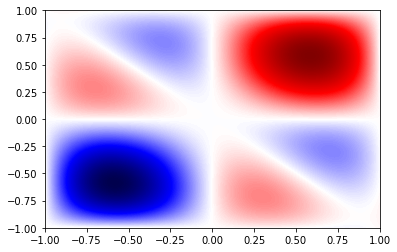

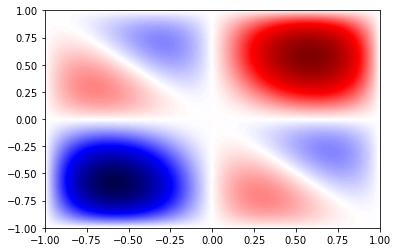

In [43]:

Max_iter =3500  
k = 1
model_10 = PhysicsInformedNN(X_u_train, u_star, X_f_train, layers, lb, ub, k , 10)
print("暂时ok")
start_time = time.time()   #计时             
MSE_hist1, a_hist1 = model_10.train(Max_iter)    #开始训练（返回的是？）
np.save("MSE_hist_1",MSE_hist1)
np.save("a_history_1",a_hist1)

elapsed = time.time() - start_time       #计时         
print('n=10:Training time: %.4f' % (elapsed))

#调用model的predict方法传入坐标X_star获得对应的结果u_pred和方程偏差f_pred
y=np.linspace(-1,1,100)
x =np.linspace(-1,1,100)
[X,Y]=np.meshgrid(x,y)
xy = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u_pred,f_pred = model_10.predict(xy)
out = np.hstack((xy, u_pred))
np.save("(x,y,u)1",out)
plt.figure(1)
plt.contourf(X,Y,np.reshape(u_pred,(100,100)),1000,cmap=plt.cm.seismic)
plt.savefig("predic_1.jpg")
#plt.ylim((-1.5,1.5))

plt.figure(2)
plt.contourf(X,Y,exact_fun(X,Y),1000,cmap=plt.cm.seismic)


In [44]:
y=np.linspace(-1,1,100)
x =np.linspace(-1,1,100)
[X,Y]=np.meshgrid(x,y)

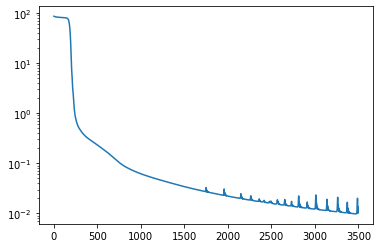

In [45]:

plt.yscale('log')
plt.plot(MSE_hist1)

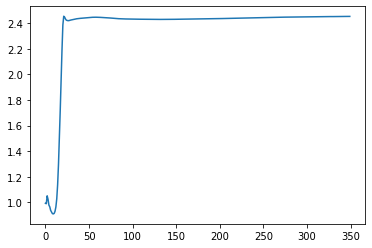

In [46]:
plt.plot(10*np.reshape(a_hist1, (-1, 1)) )

In [47]:
u_pred1, f_pred1 = model_10.predict(X_f_train)
print(f_pred1.shape)

(16400, 1)


In [27]:
y=np.linspace(-1,1,100)
x =np.linspace(-1,1,100)
[X,Y]=np.meshgrid(x,y)
xy = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
u=xy[:,0:1]+xy[:,1:2]
out = np.hstack((xy, u))
print(out)

[[-1.         -1.         -2.        ]
 [-0.97979798 -1.         -1.97979798]
 [-0.95959596 -1.         -1.95959596]
 ...
 [ 0.95959596  1.          1.95959596]
 [ 0.97979798  1.          1.97979798]
 [ 1.          1.          2.        ]]


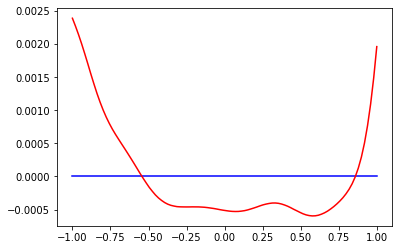

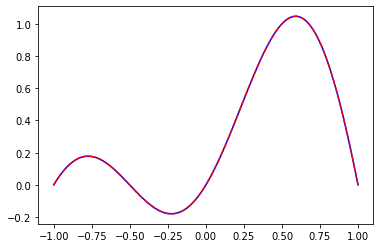

In [48]:
y=np.linspace(-1,1,100)
x1=0*np.ones(100)
x2=0.5*np.ones(100)
X1=np.hstack((x1.flatten()[:,None],y.flatten()[:,None]))
X2=np.hstack((x2.flatten()[:,None],y.flatten()[:,None]))
#print(X1)
u_pred2 = model_10.predict(X1)
u_pred3 = model_10.predict(X2)
plt.figure(1)
plt.plot(y, exact_fun(x1,y),'b')
plt.plot(y, u_pred2[0],'r')
plt.figure(2)
plt.plot(y, exact_fun(x2,y),'b')
plt.plot(y, u_pred3[0],'r--')

